In [1]:
import cobra
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

## Chapter 14 problem 8

**Fermentation to Produce Soy Sauce**: Soy sauce is prepared by fermenting a salted mixture of soybeans and wheat with several microorganisms, including yeast, over a period of 8 to 12 months. The resulting sauce (after solids are removed) is rich in lactate and ethanol.

To prevent the soy sauce from having a strong vinegar taste (vinegar is dilute acetic acid), oxygen must be kept out of the fermentation tank. Why?

**Approach**
1. Add fermentation reactions to glycolysis model (from pyruvate)
 - Ethanol: ALCD2x
 - Acetate: PDH, PTAr, ACKr
2. Knock out pyr_to_ATP reaction
3. Fermentation is an adaptive mechanism to increase ATP yield. Restrict to one fermentation product and optimize for ATP
 - In aerobic and anaerobic conditions
4. Which fermentation byproduct results in the highest ATP yield in aerobic/anaerobic conditions?


In [2]:
import cobra
glycolysis = cobra.io.load_json_model('../resources/glycolysis_model.json')
ecoli = cobra.io.load_json_model('../resources/iML1515.json')

glycolysis.reactions.EX_glc__D_c.lower_bound = -1
glycolysis.reactions.EX_o2_c.lower_bound = -1000
glycolysis.reactions.pyr_to_ATP.knock_out()

# add ethanol fermentation
glycolysis.add_reaction(ecoli.reactions.ALCD2x)

# add acetate fermentation
glycolysis.add_reaction(ecoli.reactions.PDH)
glycolysis.add_reaction(ecoli.reactions.PTAr)
glycolysis.add_reaction(ecoli.reactions.ACKr)

# add outlet for ethanol + acetate
for r_id, r in {'EX_ac_c': 'ac_c -> ', 'EX_etoh_c': 'etoh_c -> ', 'PYRDC': 'h_c + pyr_c -> acald_c + co2_c'}.items():
    r_obj = cobra.Reaction(r_id)
    glycolysis.add_reaction(r_obj)
    r_obj.build_reaction_from_string(r)

In [3]:
import pandas as pd
df = pd.DataFrame()
glycolysis.reactions.EX_ac_c.knock_out()
glycolysis.reactions.EX_lac__L_c.knock_out()
glycolysis.reactions.EX_etoh_c.knock_out()
for ferm in ['EX_ac_c', 'EX_etoh_c', 'EX_lac__L_c']:
    glycolysis.reactions.get_by_id(ferm).upper_bound = 1000
    
    glycolysis.objective = 'ATPM'
    df.loc[ferm, 'Aerobic ATP'] = glycolysis.optimize().objective_value
    
    glycolysis.reactions.EX_o2_c.lower_bound = 0
    df.loc[ferm, 'Anaerobic ATP'] = glycolysis.optimize().objective_value
    glycolysis.reactions.EX_o2_c.lower_bound = -1000
    glycolysis.reactions.get_by_id(ferm).upper_bound = 0
df

,Aerobic ATP,Anaerobic ATP
EX_ac_c,14.0,0.0
EX_etoh_c,7.0,2.0
EX_lac__L_c,7.0,2.0


## Chapter 14 problem 10
**Glycolysis Shortcut:** Suppose you discovered a mutant yeast whose glycolytic pathway was shorter because of the presence of a new enzyme catalyzing the reaction:

w/ metabolite names: `glyceraldehyde 3 phosphate + h2o + nad -> nadh + h + 2-phosphoglycerate`

w/ bigg ids: `g3p_c + h2o_c + nad_c -> nadh_c + h_c + 2pg_c`

**Approach**
1. Add reaction to core model
2. Assess ATP production potential vs reaction activity


Text(0.5,0,'Shortcut flux')

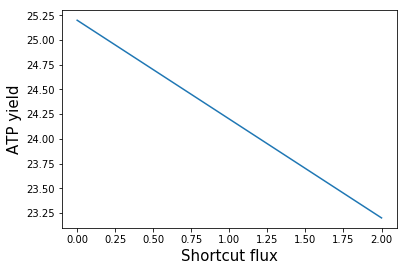

In [4]:
# Load Model
model = cobra.io.load_json_model('../resources/core_model.json')

# Add shortcut reaction
model.add_reaction(cobra.Reaction('shortcut'))
model.reactions.shortcut.build_reaction_from_string('g3p_c + h2o_c + nad_c -> nadh_c + h_c + 2pg_c')

# Assess ATP production ability
x = []
y = []
model.objective = 'shortcut'
for i in np.linspace(0, 2, 20): # Max flux through reaction is 2
    model.reactions.shortcut.lower_bound = i
    model.objective = 'ATPM'
    sol = model.optimize()
    x.append(i)
    y.append(sol.objective_value)
plt.plot(x, y)
plt.ylabel('ATP yield', size=15)
plt.xlabel('Shortcut flux', size=15)

## Chapter 16 problem 23
**Synthesis of L-Malate in Wine Making:** The tartness of some wines is due to high concentrations of L-malate. Write a sequence of reactions showing how yeast cells synthesize L-malate from glucose under anaerobic conditions in the presence of dissolved CO2 (HCO3 ). Note that the overall reaction for this fermentation cannot involve the consumption of nicotinamide coenzymes or citric acid cycle intermediates.

**Approach**
1. Ensure that all biosynthetic intermediates of malate can be synthesized in the cytosol
 - If not use bigg to find a reaction in yeast that can fulfill role
2. Optimize anaerobically to get net equation


In [6]:
model = cobra.io.load_json_model('../resources/core_model.json')
model.add_reaction(cobra.Reaction("PC"))
model.reactions.PC.build_reaction_from_string('atp_c + hco3_c + pyr_c -> adp_c + h_c + oaa_c + pi_c')
model.add_boundary(model.metabolites.mal__L_c)
model.reactions.EX_glc__D_c.lower_bound =-1
model.reactions.EX_o2_c.lower_bound = 0
model.reactions.EX_co2_c.lower_bound = -100
model.objective = 'EX_mal__L_c'
sol = model.optimize()

df = pd.DataFrame()
for r in model.reactions:
    if 'EX_' in r.id and abs(r.flux) > .01:
        df.loc[r.id, 'Exchange'] = r.flux
        print(r.id + ':', r.flux)
    elif abs(r.flux) > .01:
        print(r, r.flux)

HEX1: atp_c + glc__D_c --> adp_c + g6p_c + h_c 1.0
PGI: g6p_c <=> f6p_c 1.0
PFK: atp_c + f6p_c --> adp_c + fdp_c + h_c 1.0
FBA: fdp_c <=> dhap_c + g3p_c 1.0
TPI: dhap_c <=> g3p_c 1.0
GAPD: g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c 2.0
PGK: 3pg_c + atp_c <=> 13dpg_c + adp_c -2.0
PGM: 2pg_c <=> 3pg_c -2.0
ENO: 2pg_c <=> h2o_c + pep_c 2.0
PYK: adp_c + h_c + pep_c --> atp_c + pyr_c 2.0
MDH: mal__L_c + nad_c <=> h_c + nadh_c + oaa_c -2.0
HCO3E: co2_c + h2o_c <=> h_c + hco3_c 2.0
EX_h_c: 4.0
EX_glc__D_c: -1.0
EX_co2_c: -2.0
PC: atp_c + hco3_c + pyr_c --> adp_c + h_c + oaa_c + pi_c 2.0
EX_mal__L_c: 2.0


## Chapter 19 problem 6 

**Uncouplers of ETC:** In normal mitochondria the rate of electron transfer is tightly coupled to the demand for ATP. When the rate of use of ATP is relatively low, the rate of electron transfer is low; when demand for ATP increases, electron-transfer rate increases. Under these conditions of tight coupling, the number of ATP molecules produced per atom of oxygen consumed when NADH is the electron donor—the P/O ratio—is about 2.5.

(a) Predict the effect of a relatively low and a relatively high concentration of uncoupling agent on the rate of electron transfer and the P/O ratio.

(b) Ingestion of uncouplers causes profuse sweating and an increase in body temperature. Explain this phenomenon in molecular terms. What happens to the P/O ratio in the presence of uncouplers?

(c) The uncoupler 2,4-dinitrophenol was once prescribed as a weight-reducing drug. How could this agent, in principle, serve as a weight-reducing aid? Uncoupling agents are no longer prescribed, because some deaths occurred following their use. Why might the ingestion of uncouplers lead to death?

**Approach**
1. Use Htmi reaction to uncouple electron transport chain
2. P/O ratio can be computed as `flux_ATPS4mi / (flux_EX_o2_c * 2)`
3. Rate of electron transfer can be computed as `(flux_NADH2_u10mi + flux_FADH2ETC) / flux_ATPS4mi`


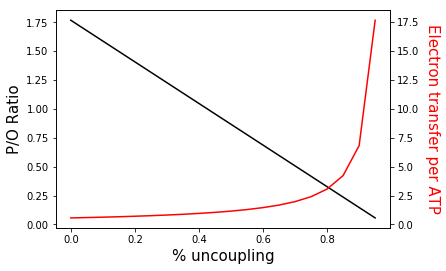

Text(0,0.5,'Glucose Uptake')

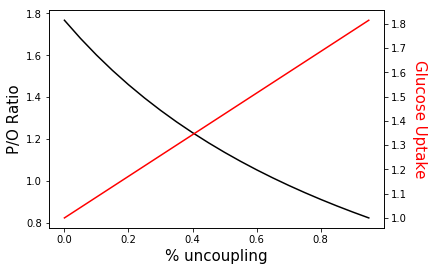

In [24]:

model = cobra.io.load_json_model('../resources/core_model.json')


x = []
y = []
y2=[]

# Find maximum uncoupling value possible
model.objective = 'Htmi'
sol = model.optimize()
for i in np.linspace(0, .95, 20):
    model.reactions.Htmi.lower_bound = i * sol.objective_value
    model.objective = 'ATPM'
    model.optimize()
    y.append(model.reactions.ATPS4mi.flux / abs((model.reactions.EX_o2_c.flux * 2)))
    y2.append((model.reactions.NADH2_u10mi.flux + model.reactions.FADH2ETC.flux) / model.reactions.ATPS4mi.flux)
    x.append(i)
plt.plot(x, y, 'k')
plt.ylabel('P/O Ratio', fontdict={'color':'k', 'size': 15})
plt.xlabel('% uncoupling', size=15)
ax2 = plt.twinx()
ax2.plot(x, y2, c='r')

ax2.set_ylabel('Electron transfer per ATP', fontdict={'color':'r',
                                                     'size': 15}, rotation=-90, labelpad=20)
plt.show()
plt.close()


model = cobra.io.load_json_model('../resources/core_model.json')
sol_1 = model.optimize()

model.objective = 'Htmi'
x = []
y = []
y2=[]
sol = model.optimize()

model.reactions.ATPM.lower_bound = sol_1.fluxes['ATPM']
model.reactions.EX_glc__D_c.lower_bound = -10
for i in np.linspace(0, .95, 20):
    model.reactions.Htmi.lower_bound = i * sol.objective_value
    
    model.objective = 'EX_glc__D_c'
    q = model.optimize()
    y.append(model.reactions.ATPS4mi.flux / abs((model.reactions.EX_o2_c.flux * 2)))
    y2.append(abs(model.reactions.EX_glc__D_c.flux))
    x.append(i)
plt.plot(x, y, 'k')
plt.ylabel('P/O Ratio', fontdict={'color':'k', 'size': 15})
plt.xlabel('% uncoupling', size=15)
ax2 = plt.twinx()
ax2.plot(x, y2, c='r')

ax2.set_ylabel('Glucose Uptake', fontdict={'color':'r',
                                                     'size': 15}, rotation=-90, labelpad=20)


## Trying chapter 19 problem 17
Effectof AKGMAL transporter KO on 

In [26]:
model = cobra.io.load_json_model('../resources/core_model.json')

In [27]:
model.optimize()

,fluxes,reduced_costs
CSm,2.0,-5.329071e-15
ACONTm,2.0,7.105427e-15
ICDHxm,2.0,-7.105427e-15
AKGDm,2.0,7.105427e-15
SUCOASm,-2.0,-0.000000e+00
...,...,...
EX_octa_c,0.0,-7.920000e+01
EX_acetone_m,0.0,0.000000e+00
EX_bhb_m,0.0,-3.600000e+01
EX_glygn2_c,0.0,-5.604000e+02


In [28]:
model.reactions.AKGMALtm.knock_out()
model.optimize()

,fluxes,reduced_costs
CSm,2.0,0.000000e+00
ACONTm,2.0,-7.105427e-15
ICDHxm,2.0,-3.552714e-15
AKGDm,2.0,0.000000e+00
SUCOASm,-2.0,-0.000000e+00
...,...,...
EX_octa_c,0.0,-8.168000e+01
EX_acetone_m,0.0,0.000000e+00
EX_bhb_m,0.0,-3.600000e+01
EX_glygn2_c,0.0,-4.812000e+02


### Trying problem 15, chapter 14

In [91]:
model = cobra.io.load_json_model('../models/core_model.json')
model.reactions.EX_o2_c.lower_bound = 0
model.add_boundary(model.metabolites.akg_m)
model.reactions.EX_akg_m.lower_bound = 0
model.objective = 'ATPM'
model.reactions.ATPM.add_metabolites({'pi_c': .5}, combine=False)

sol = model.optimize()

In [92]:
sol.f

1.9999999999999991

In [93]:
for r in model.reactions.query('EX_'):
    print(r.id, r.flux)

EX_h_c 2.0000000000000004
EX_pyr_c 0.0
EX_h2o_c 7.200589331140302e-16
EX_pi_c -1.0000000000000002
EX_glc__D_c -1.0
EX_lac__L_c 1.9999999999999996
EX_co2_c -5.114956077737329e-16
EX_o2_c 0.0
EX_octa_c 0.0
EX_acetone_m 0.0
EX_bhb_m 0.0
EX_glygn2_c 0.0
EX_Tyr_ggn_c 0.0
EX_akg_m 0.0


In [84]:
model.reactions.EX_lac__L_c.flux

1.9999999999999996

In [85]:
model.reactions.EX_pi_c.flux

-1.0000000000000002

In [96]:
model.reactions.EX_pi_c.lower_bound = -.1
sol = model.optimize()

In [97]:
sol.f

0.19999999999999585

In [98]:
for r in model.reactions.query('EX_'):
    print(r.id, r.flux)

EX_h_c 1.9999999999999998
EX_pyr_c 0.0
EX_h2o_c 0.0
EX_pi_c -0.1
EX_glc__D_c -1.0
EX_lac__L_c 1.999999999999998
EX_co2_c -3.0873829569997055e-16
EX_o2_c 5.947623346206209e-18
EX_octa_c 0.0
EX_acetone_m 0.0
EX_bhb_m 0.0
EX_glygn2_c 1.5734754434704247e-18
EX_Tyr_ggn_c 0.0
EX_akg_m 0.0


### Problem 29, chapter 14

In [99]:
model = cobra.io.load_json_model('../models/core_model.json')

In [100]:
model.reactions.EX_lac__L_c.lower_bound = -1
model.objective = 'EX_glc__D_c'

In [101]:
model.optimize()

,fluxes,reduced_costs
CSm,0.194444,2.220446e-16
ACONTm,0.194444,0.000000e+00
ICDHxm,0.194444,1.443290e-15
AKGDm,0.194444,-1.554312e-15
SUCOAS1m,-0.194444,1.554312e-15
...,...,...
EX_octa_c,0.000000,-2.750000e+00
EX_acetone_m,0.000000,0.000000e+00
EX_bhb_m,0.000000,-1.194444e+00
EX_glygn2_c,0.000000,-2.200000e+01


In [102]:
model.reactions.EX_o2_c.flux

-0.583333333333337

In [103]:
model.metabolites.atp_c.summary()

PRODUCING REACTIONS -- ATP C10H12N5O13P3 (atp_c)
------------------------------------------------
%       FLUX  RXN ID    REACTION
----  ------  --------  ---------------------------------
100%   0.806  ATPtm     adp_c + atp_m --> adp_m + atp_c

CONSUMING REACTIONS -- ATP C10H12N5O13P3 (atp_c)
------------------------------------------------
%       FLUX  RXN ID    REACTION
----  ------  --------  ---------------------------------
100%   0.806  PGK       3pg_c + atp_c <=> 13dpg_c + adp_c


### Problem 29, chapter 14

In [126]:
model = cobra.io.load_json_model('../models/core_model.json')
model.objective = 'ATPM'
sol1 = model.optimize()
model.add_boundary(model.metabolites.oaa_c)
model.objective = 'EX_oaa_c'
model.reactions.PCm.knock_out()
sol2 = model.optimize()

In [127]:
sol1.f

25.19999999999994

In [128]:
sol2.f

0.0

In [119]:
df = (sol2.fluxes + 1) / (sol1.fluxes + 1)

In [167]:
model = cobra.io.load_json_model('../models/core_model.json')
model.add_boundary(model.metabolites.cit_m)
model.reactions.EX_cit_m.lower_bound = 0
model.reactions.NADM.knock_out()
sol = model.optimize()

df = pd.DataFrame()
x = []
y = []
for i in np.linspace(0, .5, 20):
    for r in ['ACONTm', 'NADH2_u10mi']:
        model.reactions.get_by_id(r).lower_bound = i * sol.fluxes[r]
        model.reactions.get_by_id(r).upper_bound = i * sol.fluxes[r]
        sol2 = model.optimize()
        print(sol2.f)
        df.loc[str(i), 'cit'] = sol2.fluxes['EX_cit_m']

9.2
2.0
2.036062378167643
2.61052631578947
2.484210526315792
3.221052631578941
3.0947368421052506
3.8315789473683877
3.705263157894726
4.442105263157842
4.315789473684192
5.052631578947308
4.926315789473658
5.663157894736759
5.536842105263107
6.273684210526182
6.14736842105267
6.8842105263157585
6.757894736841999
7.49473684210513
7.368421052631394
8.105263157894703
7.978947368421069
8.715789473684065
8.589473684210393
9.326315789473671
9.19999999999987
9.936842105263072
9.810526315789437
10.547368421052479
10.421052631578835
11.157894736841953
11.03157894736832
11.768421052631389
11.642105263157802
12.378947368420853
12.252631578947284
12.989473684210465
12.863157894736695
13.599999999999913


cobra/util/solver.py:408 UserWarning: solver status is 'infeasible'


In [332]:
df

,Exchange
EX_h_c,3.333333e-01
EX_pyr_c,1.657374e-14
EX_h2o_c,2.666667e+00
EX_pi_c,-4.817403e-15
EX_lac__L_c,-5.033011e-15
EX_co2_c,2.666667e+00
EX_o2_c,-5.000000e+00
EX_octa_c,-1.000000e+00
EX_bhb_m,1.333333e+00


In [130]:
a = cobra.flux_analysis.sample(model, 1000)

In [160]:
a.corr().loc['ACONTm', 'NADH2_u10mi']

0.7826047902300649

In [157]:
df

,Exchange
EX_h_c,4.0
EX_glc__D_c,-1.0
EX_co2_c,-2.0
EX_mal__L_c,2.0


In [19]:
with model:
    model.reactions.NADH2_u10mi.knock_out()
    print(model.optimize())
    
    model.reactions.CY.knock_out()
    print(model.optimize())

<Solution 2.000 at 0x1198c7240>


In [21]:
model.reactions.

Reaction identifier,CYOR_u10mi
Name,CYOR u10mi
Memory address,0x01191ea320
Stoichiometry,2.0 ficytC_m + 2.0 h_m + q10h2_m --> 2.0 focytC_m + 4.0 h_i + q10_m 2.0 Ferricytochrome c + 2.0 H+ + Ubiquinol-10 --> 2.0 Ferrocytochrome C + 4.0 H+ + Ubiquinone-10
GPR,(7384_AT1 and 7388_AT1 and 4519_AT1 and 29796_AT2 and 10975_AT1 and 7385_AT1 and 7386_AT1 and 153...
Lower bound,0.0
Upper bound,1000.0


In [17]:
model = cobra.io.load_json_model('../resources//core_model.json')


[<Reaction CSm at 0x1191dfb00>,
 <Reaction ACONTm at 0x1191dff28>,
 <Reaction ICDHxm at 0x1191e3160>,
 <Reaction AKGDm at 0x1191e35c0>,
 <Reaction SUCOASm at 0x1191e35f8>,
 <Reaction SUCD1m at 0x1191e3710>,
 <Reaction FUMm at 0x12265aa58>,
 <Reaction MDHm at 0x1191e3cc0>,
 <Reaction NADH2_u10mi at 0x1191e3d30>,
 <Reaction FADH2ETC at 0x1191e3fd0>,
 <Reaction CYOR_u10mi at 0x1191ea320>,
 <Reaction CYOOm2i at 0x1191ea208>,
 <Reaction ATPS4mi at 0x1191ea4a8>,
 <Reaction Htmi at 0x1227b7128>,
 <Reaction HEX1 at 0x1227b7208>,
 <Reaction PGI at 0x1191fd438>,
 <Reaction PFK at 0x1228e8518>,
 <Reaction FBA at 0x1191fb668>,
 <Reaction TPI at 0x1191fb898>,
 <Reaction GAPD at 0x1191fbd30>,
 <Reaction PGK at 0x12270ecf8>,
 <Reaction PGM at 0x12270ebe0>,
 <Reaction ENO at 0x12270e400>,
 <Reaction PYK at 0x122715278>,
 <Reaction ADK1 at 0x122706908>,
 <Reaction PDHm at 0x1226fdcc0>,
 <Reaction LDH_L at 0x1226fd5c0>,
 <Reaction G6PDH2r at 0x12270be48>,
 <Reaction PGL at 0x1227cf390>,
 <Reaction GND a

In [193]:
# Chapter 17, problem 13 how much water from kilogram of fat

model = cobra.io.load_json_model('../models/core_model.json')
model.add_boundary(model.metabolites.coa_m)
model.reactions.EX_co2_c.lower_bound = -100
model.reactions.EX_glc__D_c.lower_bound = 0
model.reactions.EX_octa_c.lower_bound = -1
model.add_boundary(model.metabolites.accoa_m)
model.objective = 'EX_accoa_m'
sol = model.optimize()

df = pd.DataFrame()
for r in model.reactions:
    if 'EX_' in r.id and r.x != 0:
        df.loc[r.id, 'Exchange'] = r.x
        print(r.id + ':', r.x)

In [220]:
# Chapter 17, problem 16 ketone bodies in diabetes

model = cobra.io.load_json_model('../models/core_model.json')
model.reactions.EX_glc__D_c.lower_bound = 0
model.reactions.EX_co2_c.lower_bound = -100
model.reactions.EX_octa_c.lower_bound = -1
model.reactions.EX_octa_c.upper_bound = -1
model.reactions.EX_o2_c.lower_bound = -5 # half of the full activity
sol = model.optimize()

df = pd.DataFrame()
for r in model.reactions:
    if 'EX_' in r.id and r.x != 0:
        df.loc[r.id, 'Exchange'] = r.x
        print(r.id + ':', r.x)
        
model.reactions.EX_bhb_m.knock_out()
model.reactions.EX_acetone_m.knock_out()
#model.add_boundary(model.metabolites.accoa_c)
#model.reactions.EX_accoa_c.upper_bound= 100
model.add_reaction(cobra.Reaction('accoa_to_coa'))
model.reactions.accoa_to_coa.build_reaction_from_string('accoa_m -> coa_m')

model.optimize()

EX_h_c: 0.3333333333334264
EX_pyr_c: 1.6573744473272203e-14
EX_h2o_c: 2.6666666666665657
EX_pi_c: -4.817402515547371e-15
EX_lac__L_c: -5.033011044967297e-15
EX_co2_c: 2.6666666666665746
EX_o2_c: -5.0
EX_octa_c: -1.0
EX_bhb_m: 1.3333333333334985


,fluxes,reduced_costs
CSm,1.0,-5.551115e-17
ACONTm,1.0,0.000000e+00
ICDHxm,1.0,0.000000e+00
AKGDm,1.0,0.000000e+00
SUCOAS1m,0.0,0.000000e+00
...,...,...
EX_acetone_m,0.0,3.122502e-17
EX_bhb_m,0.0,0.000000e+00
EX_glygn2_c,0.0,-5.000000e+01
EX_Tyr_ggn_c,0.0,0.000000e+00


In [216]:
find_sinks_sources(model, mets_to_skip=['octa_c', 'ac_c', 'occoa_c', 'occoa_m'])

cobra/util/solver.py:408 UserWarning: solver status is 'infeasible'


Before adding sinks:  <Solution infeasible at 0x1146cc9b0>
Maximize
1.0*ATPM - 1.0*ATPM_reverse_5b752
After adding sinks:  <Solution 1000.000 at 0x1147fd748>
250
Keeping 3hocoa_m_sink 0.1384083044981559 1.0
3ooctACP_c_source -1.161432061635992e-13
malACP_c_source 1.5158245029548803e-13
fad_m_sink -1.7763568394002505e-15
amp_c_source -2.220446049250313e-16
nadh_m_sink -8.881784197001252e-16


Name,None
Memory address,0x01148ebef0
Number of metabolites,129
Number of reactions,135
Objective expression,0
Compartments,"m, i, c, r,"


In [182]:
from fba4l.helper_functions.node_relaxing import find_sinks_sources
find_sinks_sources(model, mets_to_skip = ['glygn2_c', 'glygn1_c', 'ggn_c', 'udpg_c', 'dxtrn_c',
                                       '2pg_c', '3pg_c', 'e4p_c', 'mal__L_c', 'xu5p__D_c',
                                       'ru5p__D_c', 'dhap_c', 'g3p_c', 'r5p_c',
                                       'lac__L_c', 'glygn3_c', 's7p_c', 'g1p_c', 'g6p_c',
                                        'glc__D_c', 'glc__D_r', 'f6p_c', 'g6p_r', 'fdp_c',
                                        '6pgl_c', 'oaa_c', 'pep_m', 'pep_c', '13dpg_c',
                                        '6pgc_c', 'octa_c'])

Before adding sinks:  <Solution 0.000 at 0x1133a1240>
Maximize
1.0*EX_accoa_m - 1.0*EX_accoa_m_reverse_188b5
After adding sinks:  <Solution 1000.000 at 0x113a9ed68>
196


Name,None
Memory address,0x0113e42e80
Number of metabolites,129
Number of reactions,134
Objective expression,0
Compartments,"m, i, c, r,"


In [228]:
# Chapter 17, problem 17 consequences of a high fat diet

model = cobra.io.load_json_model('../models/core_model.json')
model.reactions.CSm.add_metabolites({'oaa_c': -.99}, # need to force activity of anaplerotic
                                    combine=False)
model.reactions.EX_co2_c.lower_bound = -100
model.reactions.EX_octa_c.lower_bound = -1
model.reactions.EX_octa_c.upper_bound = -1
model.reactions.EX_o2_c.lower_bound = -100

sol = model.optimize()
print(sol.fluxes['CSm'])
model.reactions.EX_glc__D_c.lower_bound = 0
sol = model.optimize()
print(sol.fluxes['CSm'])

2.0202020202020154
0.0


In [328]:
model.reactions.ATPM.lower_bound

0.0

In [326]:
q.fluxes.ATPM

0.0